In [11]:
# !pip install numpy

In [12]:
# !pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.0.0+cu114.html

Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu114.html
^C


In [9]:
# !pip install torch_geometric

ERROR: Could not find a version that satisfies the requirement torch_geometric (from versions: none)
ERROR: No matching distribution found for torch_geometric


In [10]:
# !pip install torch-geometric-temporal

^C
ERROR: Operation cancelled by user


In [255]:
import pandas as pd
from tqdm import tqdm
import os
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import DCRNN, GConvGRU, GConvLSTM
import random
import matplotlib.pyplot as plt

In [256]:
torch.cuda.is_available()

True

In [257]:
num_nodes = 50
total_time_in_dataset = 237
window_size = 30
num_node_features_closing_price_only = 1
num_node_features_all = 5
num_epochs = 100
distance_csv_path = "./Data/dataset/Distance_Return.csv"

In [258]:
df = pd.read_csv(distance_csv_path)

In [259]:
df = df.drop(["KVUE"], axis=1)
df = df.drop(277, axis=0)
df = df.drop(["Unnamed: 0"], axis=1)

In [260]:
df = df.iloc[:num_nodes, :num_nodes]

In [261]:
# c = (df>1e-4)

# a = (df>0)
# b = (df<=0.7)
# c = a & b

# d = (df<2)
# e = (df>=1.3)
# f = e & d

# c = c | f

c = (df>=0)
for i in range(len(c)):
    for j in range(len(c)):
        if(i==j):
            c.iloc[i][j] = False
# c

In [262]:
companies = list(df.columns)

In [263]:
edge_list_x = []
edge_list_y = []
weight = []
for i in tqdm(range(len(companies))):
    for j in range(len(companies)):
        if(c.iloc[i][j]):
#             print(i, j)
            edge_list_x.append(i)
            edge_list_y.append(j)
            weight.append(df.iloc[i][j])
            
#define the edge_index
edge_list = np.zeros((2,len(edge_list_x)))
edge_list[0] = edge_list_x
edge_list[1] = edge_list_y
edge_index = torch.from_numpy(edge_list).long()

#define the edge weights
edge_weights = np.array(weight)
edge_weights = torch.from_numpy(edge_weights).float()
# edge_weights

100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 215.20it/s]


In [264]:
node_indices = [i for i in range(len(companies))]
node_dict = {i:j for i,j in zip(node_indices, companies)}
reverse_node_dict = {i:j for i,j in zip(companies, node_indices)}

In [265]:
len(edge_weights)

2450

# Closing Price Only

In [1]:
path = "/kaggle/input/companygraphdata/dataset/One_Year_Daily_Data/"
closing_price_matrix = np.zeros((num_nodes, total_time_in_dataset))
min_max_dict = {}
maxx_stock = -100000
minn_stock = 100000

for company in companies:
    closing_price = list(pd.read_csv(path + company+"_daily_data.csv")["close"])[:total_time_in_dataset]
    index = reverse_node_dict[company]
    closing_price_matrix[index] = closing_price
    maxx_stock = max(maxx_stock, max(closing_price))
    minn_stock = min(minn_stock, min(closing_price))


closing_price_matrix = torch.from_numpy(closing_price_matrix).float()
closing_price_matrix = (closing_price_matrix - minn_stock) / (maxx_stock - minn_stock)
closing_price_matrix

In [ ]:
X = []
Y = []
for i in range(207):
    X.append(closing_price_matrix[:,i:i+window_size])
    Y.append(closing_price_matrix[:,i+window_size])

In [136]:
train_x = X[:107]
train_y = Y[:107]
val_x = X[:107:157]
val_y = Y[:107:157]
test_x = X[157:]
test_y = Y[157:]

In [137]:
random.shuffle(train_x)
random.shuffle(train_y)
random.shuffle(val_x)
random.shuffle(val_y)
random.shuffle(test_x)
random.shuffle(test_y)

# GRU

In [ ]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features, window_size):
        super(RecurrentGCN, self).__init__()
        self.recurrent = GConvGRU(node_features, 8, 2)
        self.linear = torch.nn.Linear(8, 1)
        self.window_size = window_size
        self.node_features = node_features

    def forward(self, x, edge_index, edge_weight):
        h = None
        for i in range(self.window_size):
            input_x = x[:,i].view(num_nodes,self.node_features)
            h = self.recurrent(input_x, edge_index, edge_weight, h)
        h = F.relu(h)
        h = self.linear(h)
        return h

In [ ]:
model = RecurrentGCN(
    node_features=num_node_features_closing_price_only, 
    window_size=window_size
)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
model.train()
cost_arr = []

for epoch in tqdm(range(num_epochs)):
    ii = 0
    cost = 0
    for x,y in zip(train_x, train_y):
        print(ii, end=" ")
        y_hat = model(x, edge_index, edge_weights)
        cost += torch.mean((y_hat-y)**2)
        ii+=1
    cost/=len(train_x)
    cost.backward()
    optimizer.step()
    optimizer.zero_grad()
    print(cost)
    cost_arr.append(cost)

# LSTM

In [ ]:
class RecurrentGCNLSTM(torch.nn.Module):
    def __init__(self, node_features, window_size):
        super(RecurrentGCNLSTM, self).__init__()
        self.linear_s = torch.nn.Linear(1,4)
        self.recurrent = GConvLSTM(4, 4, 2)
        self.linear = torch.nn.Linear(4, 1)
        self.window_size = window_size
        self.node_features = 4

    def forward(self, x, edge_index, edge_weight):
        h = None
        c = None
        for i in range(self.window_size):
            input_x = x[:,i].view(num_nodes,1)
            input_x = self.linear_s(input_x)
            h,c = self.recurrent(input_x, edge_index, edge_weight, h, c)
        h = F.relu(h)
        h = self.linear(h)
        return h

In [ ]:
model = RecurrentGCNLSTM(
    node_features=num_node_features_closing_price_only, 
    window_size=window_size
)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
model.train()

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
cost_arr = []

for epoch in tqdm(range(5)):
    ii = 0
    cost = 0
    for x,y in zip(train_x, train_y):
        print(ii, end=" ")
        y_hat = model(x, edge_index, edge_weights)
        cost += torch.mean((y_hat-y)**2)
        ii+=1
    cost/=len(train_x)
    cost.backward()
    optimizer.step()
    optimizer.zero_grad()
    print(cost)
    cost_arr.append(cost)

# All Features

In [290]:
path = "./Data/dataset/One_Year_Daily_Data/"

In [291]:
def min_max_2d(data):
    minn = 1000000000
    maxx = -1000000000
    for i in range(len(data)):
        minn = min(minn, min(data[i]))
        maxx = max(maxx, max(data[i]))
    
#     data = (data-minn) / (maxx-minn)
    data = torch.from_numpy(data).float()
    return data, maxx, minn

In [292]:
matrix = np.zeros((num_nodes, total_time_in_dataset, num_node_features_all))
c_price_matrix = np.zeros((num_nodes, total_time_in_dataset))
o_price_matrix = np.zeros((num_nodes, total_time_in_dataset))
h_price_matrix = np.zeros((num_nodes, total_time_in_dataset))
l_price_matrix = np.zeros((num_nodes, total_time_in_dataset))
v_price_matrix = np.zeros((num_nodes, total_time_in_dataset))

for company in companies:
    d = pd.read_csv(path + company+"_daily_data.csv")
    open_p = d["open"][:total_time_in_dataset]
    close_p = d["close"][:total_time_in_dataset]
    high_p = d["high"][:total_time_in_dataset]
    low_p = d["high"][:total_time_in_dataset]
    volume_p = d["volume"][:total_time_in_dataset]
    
    index = reverse_node_dict[company]
    
    c_price_matrix[index] = close_p/max(close_p)
    o_price_matrix[index] = open_p/max(open_p)
    h_price_matrix[index] = high_p/max(high_p)
    l_price_matrix[index] = low_p/max(low_p)
    v_price_matrix[index] = volume_p/max(volume_p)

c_price_matrix, cmx, cmn = min_max_2d(c_price_matrix)
o_price_matrix, omx, omn = min_max_2d(o_price_matrix)
h_price_matrix, hmx, hmn = min_max_2d(h_price_matrix)
l_price_matrix, lmx, lmn = min_max_2d(l_price_matrix)
v_price_matrix, vmx, vmn = min_max_2d(v_price_matrix)

matrix = torch.stack([c_price_matrix, o_price_matrix, h_price_matrix, l_price_matrix, v_price_matrix], -1)  

In [293]:
X = []
Y = []
for i in range(207):
    X.append(matrix[:,i:i+window_size])
    Y.append(matrix[:,i+window_size][:,1])

In [294]:
train_x = X[:167]
train_y = Y[:167]
val_x = X[:167:177]
val_y = Y[:177:177]
test_x = X[177:]
test_y = Y[177:]

In [295]:
# random.shuffle(train_x)
# random.shuffle(train_y)
# random.shuffle(val_x)
# random.shuffle(val_y)
# random.shuffle(test_x)
# random.shuffle(test_y)

In [296]:
# torch.cuda.device_count()

In [297]:
edge_index = edge_index.to("cuda")
edge_weights = edge_weights.to("cuda")
for i in train_x:
    i = i.to("cuda")
for i in train_y:
    i = i.to("cuda")

# LSTM

In [298]:
huber_loss = torch.nn.HuberLoss(reduction='mean', delta=1.0)

In [299]:
# class RecurrentGCNLSTM(torch.nn.Module):
#     def __init__(self, node_features, window_size):
#         super(RecurrentGCNLSTM, self).__init__()
#         self.linear_s = torch.nn.Linear(5,8)
#         self.recurrent = GConvLSTM(8, 16, 2)
#         self.recurrent2 = GConvLSTM(16, 16, 2)
#         self.linear = torch.nn.Linear(16, 4)
#         self.linear_e = torch.nn.Linear(4,1)
#         self.window_size = window_size
#         self.node_features = 5
#         self.a = torch.nn.Tanh()

#     def forward(self, x, edge_index, edge_weight):
#         h = None
#         c = None
#         h1 = None
#         c1 = None
#         for i in range(self.window_size):
#             input_x = x[:,i].view(num_nodes,5)
#             input_x = self.linear_s(input_x)
#             h1 ,c1 = self.recurrent(input_x, edge_index, edge_weight, h1, c1)
#             h1 = self.a(h1)
#             h, c = self.recurrent2(h1, edge_index, edge_weight, h, c)
#         h = F.relu(h)
#         h = self.linear(h)
#         h = self.linear_e(h)
#         return h

class RecurrentGCNLSTM(torch.nn.Module):
    def __init__(self, node_features, window_size):
        super(RecurrentGCNLSTM, self).__init__()
#         self.linear_s = torch.nn.Linear(5,16)
        self.recurrent = GConvLSTM(5, 16, 2)
#         self.recurrent2 = GConvLSTM(, 32, 2)
        self.linear = torch.nn.Linear(16, 8)
        self.linear_e = torch.nn.Linear(8,1)
        self.window_size = window_size
        self.node_features = 5
        self.a = torch.nn.Tanh()

    def forward(self, x, edge_index, edge_weight):
        h = None
        c = None
        for i in range(self.window_size):
            input_x = x[:,i].view(num_nodes,5)
            h ,c = self.recurrent(input_x, edge_index, edge_weight, h, c)
        h = F.relu(h)
        h = self.linear(h)
        h = self.linear_e(h)
        return h

In [300]:
def calculate_val_loss(modell):
    modell.eval()
    loss = 0
    for x,y in zip(val_x, val_y):
        x = x.to("cuda")
        y = y.to("cuda")
        empt = torch.tensor([[], []]).long().to("cuda")
        y_hat = modell(x, empt, None)
        loss += torch.mean((y_hat-y)**2)
#         loss += huber_loss(y_hat.view(1,1), y.view(1,1))
    return loss/len(val_x)

In [301]:
model = RecurrentGCNLSTM(
    node_features=num_node_features_closing_price_only, 
    window_size=window_size
)
model.to("cuda")
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=7, factor=0.05)

In [302]:
train_loss = []
val_loss = []
model.train()

RecurrentGCNLSTM(
  (recurrent): GConvLSTM(
    (conv_x_i): ChebConv(5, 16, K=2, normalization=sym)
    (conv_h_i): ChebConv(16, 16, K=2, normalization=sym)
    (conv_x_f): ChebConv(5, 16, K=2, normalization=sym)
    (conv_h_f): ChebConv(16, 16, K=2, normalization=sym)
    (conv_x_c): ChebConv(5, 16, K=2, normalization=sym)
    (conv_h_c): ChebConv(16, 16, K=2, normalization=sym)
    (conv_x_o): ChebConv(5, 16, K=2, normalization=sym)
    (conv_h_o): ChebConv(16, 16, K=2, normalization=sym)
  )
  (linear): Linear(in_features=16, out_features=8, bias=True)
  (linear_e): Linear(in_features=8, out_features=1, bias=True)
  (a): Tanh()
)

In [307]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [308]:
for epoch in tqdm(range(1)):
    ii = 0
    cost = 0
    for x,y in zip(train_x, train_y):
        print(ii, end=" ")
        x = x.to("cuda")
        y = y.to("cuda")
        empt = torch.tensor([[], []]).long().to("cuda")
        y_hat = model(x, empt, None)
        cost += torch.mean(((y_hat-y)**2))
#         cost += huber_loss(y_hat.view(1,1), y.view(1,1))
        ii+=1
        #ohyeahthatsfacts
    cost/=len(train_x)
    cost.backward()
    optimizer.step()
    optimizer.zero_grad()
    train_loss.append(cost)
    validation_loss = calculate_val_loss(model)
    print("Train Loss: ", cost, " Val Loss: ", validation_loss)
    val_loss.append(validation_loss)
#     scheduler.step(validation_loss)
    if (epoch%10==0):
        torch.save(model.state_dict(), "./model/"+str(epoch)+".pt")

  0%|                                                     | 0/1 [00:00<?, ?it/s]

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 

100%|█████████████████████████████████████████████| 1/1 [00:50<00:00, 50.47s/it]

Train Loss:  tensor(0.0155, device='cuda:0', grad_fn=<DivBackward0>)  Val Loss:  tensor(0.0252, device='cuda:0', grad_fn=<DivBackward0>)


In [228]:
val_loss

[tensor(0.5795, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.4981, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.4164, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.3311, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.2449, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.1623, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.0899, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.0362, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.0068, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(8.0987e-05, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(1.3052e-05, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.0003, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>)]

In [229]:
train_loss

[tensor(0.5041, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.4255, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.3561, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.2899, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.2204, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.1511, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.0880, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.0377, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.0077, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.0165, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.0136, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.0109, device='cuda:0', grad_fn=<DivBackward0>)]

In [230]:
tr = [train_loss[i].to("cpu").detach().numpy() for i in range(len(train_loss))]
vl = [val_loss[i].to("cpu").detach().numpy() for i in range(len(val_loss))]

# Eval

In [309]:
model.eval()
cost = 0
yy = []
yyy = []
xx = []
for x,y in tqdm(zip(test_x, test_y)):
    x = x.to("cuda")
    y = y.to("cuda")
    y_hat = model(x, edge_index, edge_weights)
    yy.append(y_hat)
    yyy = y
    xx = x
    cost = cost + torch.mean((y_hat-y)**2)
#     cost += huber_loss(y_hat, y)
cost = cost/len(test_x)
cost = cost.item()
print("MSE: {:.4f}".format(cost))

30it [00:08,  3.66it/s]

MSE: 0.0435


In [310]:
comp = 0
actual_price = []
pred_price = []

for i,j in zip(test_y,yy):
    actual_price.append(i[comp].to("cpu").detach().numpy())
    pred_price.append(j[comp].to("cpu").detach().numpy())


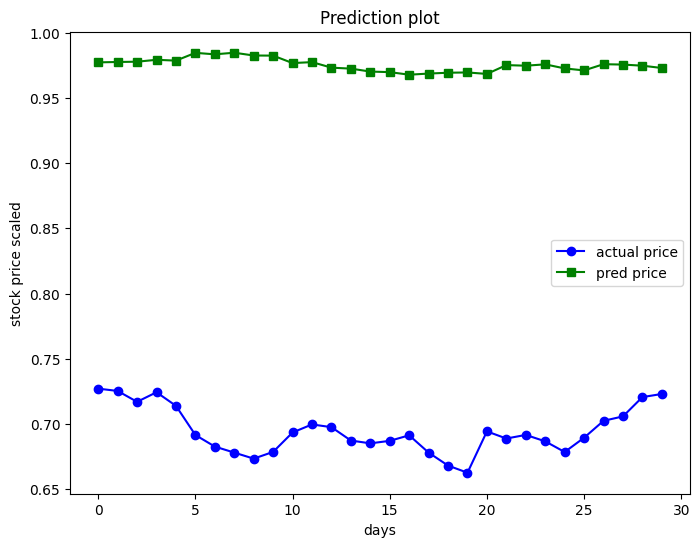

In [312]:
# Define the data for each line graph
x1 = [i for i in range(30)]
y1 = actual_price

x2 = [i for i in range(30)]
y2 = pred_price

# Create the plot
plt.figure(figsize=(8, 6))

# Plot the first line graph
plt.plot(x1, y1, label='actual price', marker='o', color='b')

# Plot the second line graph
plt.plot(x2, y2, label='pred price', marker='s', color='g')

# Add labels and title
plt.xlabel('days')
plt.ylabel('stock price scaled')
plt.title('Prediction plot')

# Add legend
plt.legend()

# Show the plot
# plt.grid(True)
plt.show()

In [287]:
model.eval()
cost = 0
yy = []
yyy = []
xx = []
for x,y in tqdm(zip(train_x, train_y)):
    x = x.to("cuda")
    y = y.to("cuda")
    y_hat = model(x, edge_index, edge_weights)
    yy.append(y_hat)
    yyy = y
    xx = x
    cost = cost + torch.mean((y_hat-y)**2)
cost = cost/len(x)
cost = cost.item()
print("MSE: {:.4f}".format(cost))

107it [00:29,  3.67it/s]

MSE: 0.0185


In [288]:
comp = 0
actual_price = []
pred_price = []

for i,j in zip(train_y,yy):
    actual_price.append(i[comp].to("cpu").detach().numpy())
    pred_price.append(j[comp].to("cpu").detach().numpy())

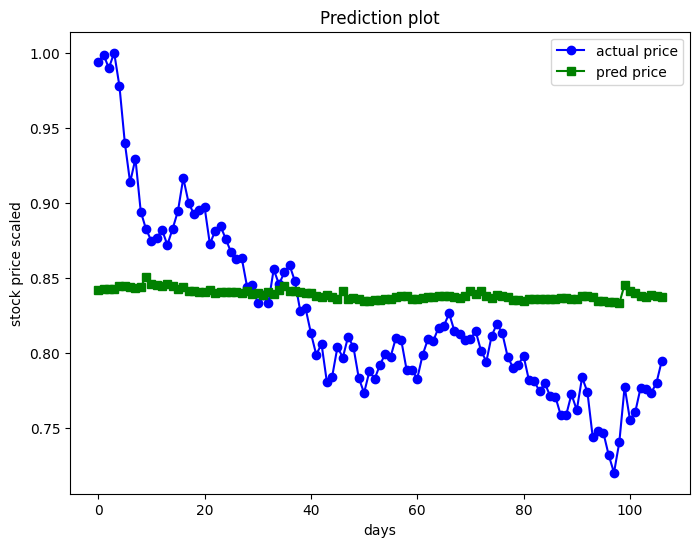

In [289]:
# Define the data for each line graph
x1 = [i for i in range(107)]
y1 = actual_price

x2 = [i for i in range(107)]
y2 = pred_price

# Create the plot
plt.figure(figsize=(8, 6))

# Plot the first line graph
plt.plot(x1, y1, label='actual price', marker='o', color='b')

# Plot the second line graph
plt.plot(x2, y2, label='pred price', marker='s', color='g')

# Add labels and title
plt.xlabel('days')
plt.ylabel('stock price scaled')
plt.title('Prediction plot')

# Add legend
plt.legend()

# Show the plot
# plt.grid(True)
plt.show()